In [6]:
import pandas as pd
import requests
import time
from tqdm import tqdm

# Load Sites.csv
results_df = pd.read_csv('sensor_quality.csv')
output_file = "sensor_quality_2015-2024_2.csv"

# Define the API URL template
API_URL_TEMPLATE = "https://webtris.nationalhighways.co.uk/api/v1.0/quality/overall?sites={}&start_date={}&end_date={}"

# Define the years to query
years = range(2015, 2025)

# Iterate over each sensor ID with progress tracking
for index, row in tqdm(results_df.iterrows(), total=results_df.shape[0], desc="Processing Sensors"):
    sensor_id = row['Id']
    for year in tqdm(years, leave=False, desc=f"Years for Sensor {sensor_id}"):
        start_date = f"0101{year}"
        end_date = f"3112{year}"
        # if pd.isna(results_df.at[index, f"{year}_data_quality"]):
        try:
            # Make the API request
            url = API_URL_TEMPLATE.format(sensor_id, start_date, end_date)
            response = requests.get(url)
            
            # Check if the request was successful
            if response.status_code == 200:
                data = response.json()
                # Extract data_quality value if available
                data_quality = data.get("data_quality", None)
            else:
                print(f"Error {response.status_code} for sensor {sensor_id} year {year}")
                data_quality = None
        except Exception as e:
            print(f"Exception for sensor {sensor_id} year {year}: {e}")
            data_quality = None
        
        # Save the data_quality value to the results DataFrame
        results_df.at[index, f"{year}_data_quality"] = data_quality

        # Respect API rate limits
        time.sleep(0)  # Adjust as necessary to avoid hitting rate limits

    # Save progress every 100 sensors
    if (index + 1) % 100 == 0:
        results_df.to_csv(output_file, index=False)

# Save the final results to a CSV file
results_df.to_csv(output_file, index=False)

print("Data collection complete.")

Processing Sensors: 100%|██████████| 19364/19364 [4:57:44<00:00,  1.08it/s]  


Data collection complete.


In [ ]:
results_df.head()

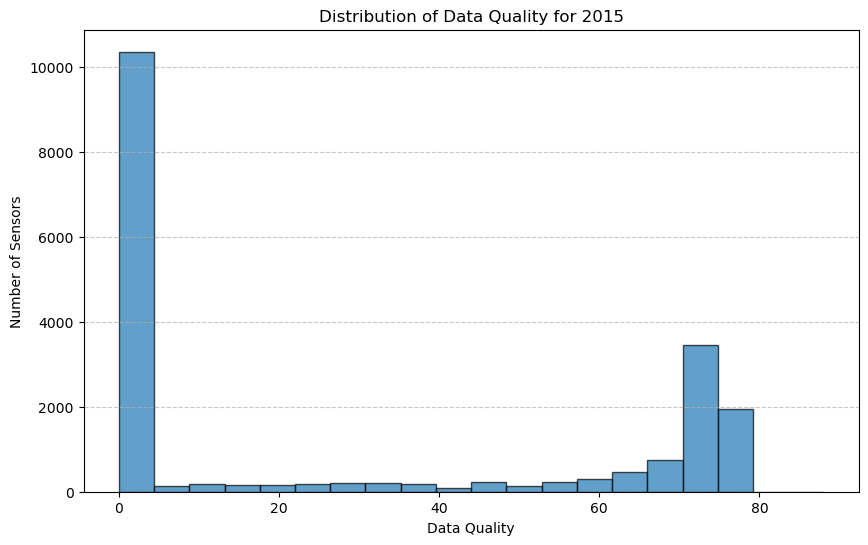

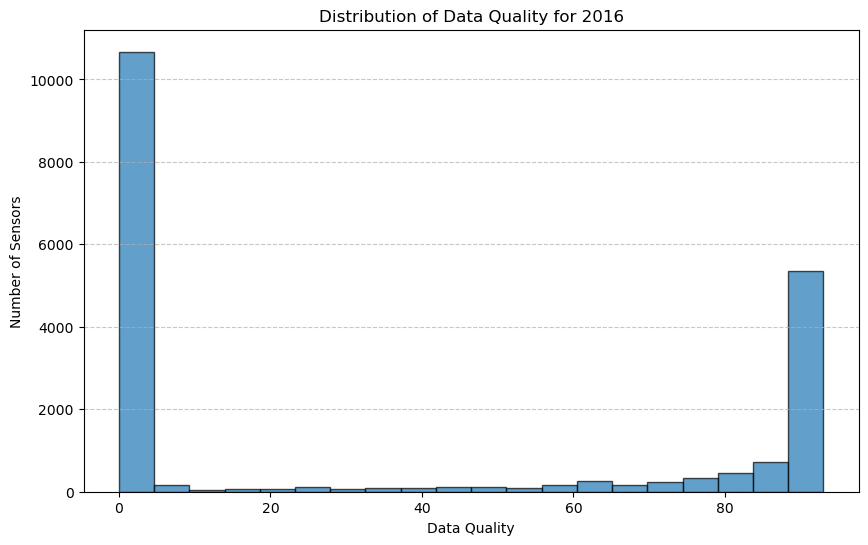

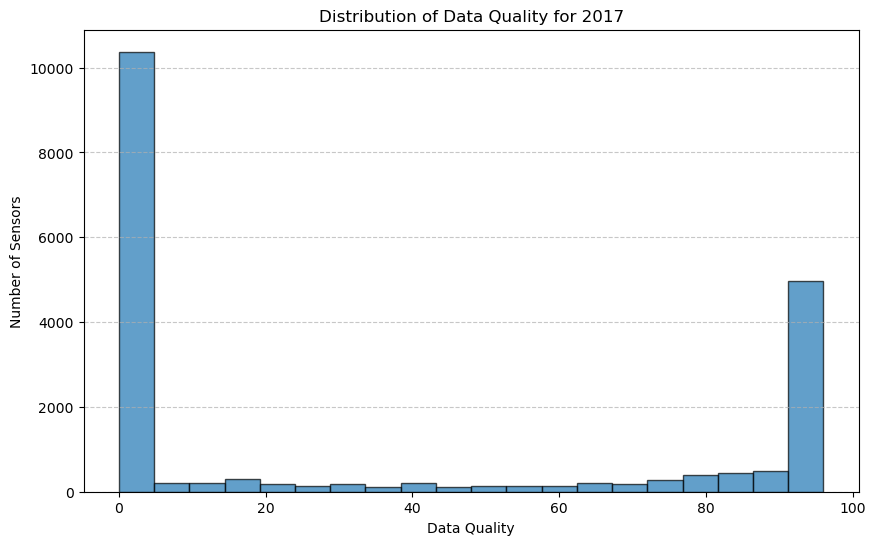

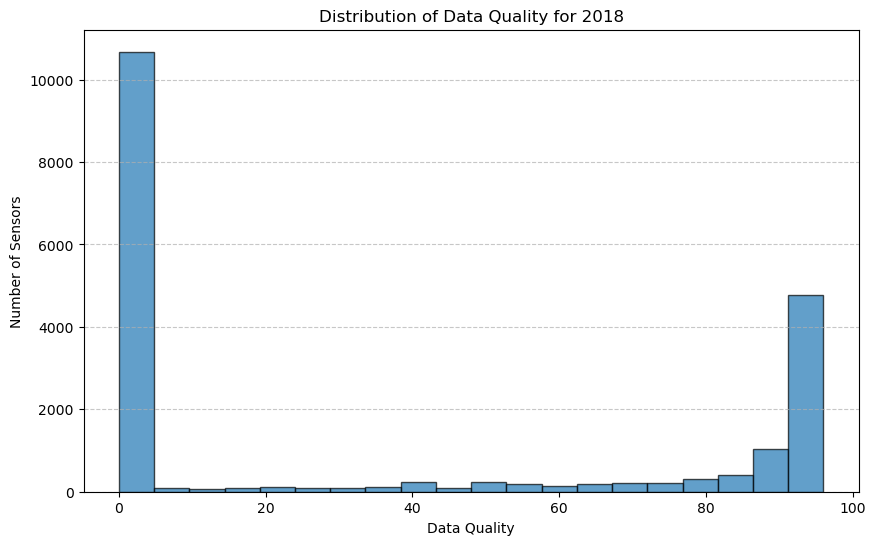

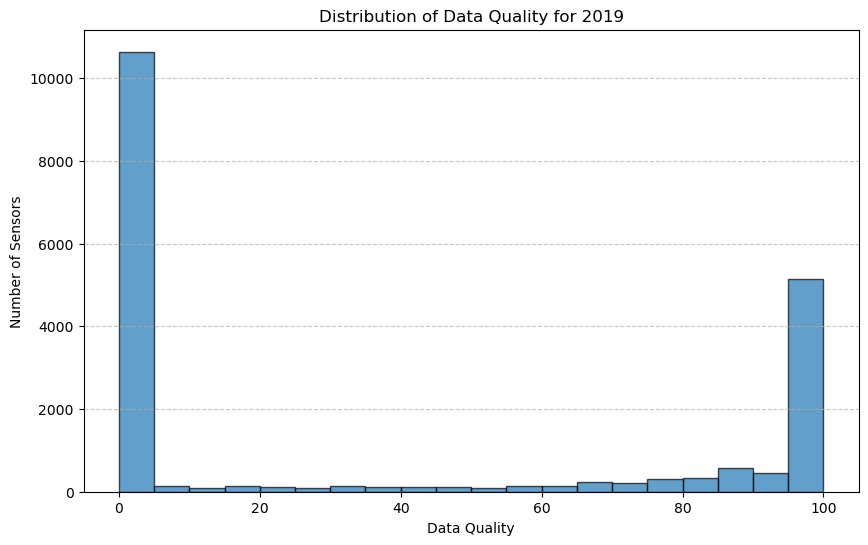

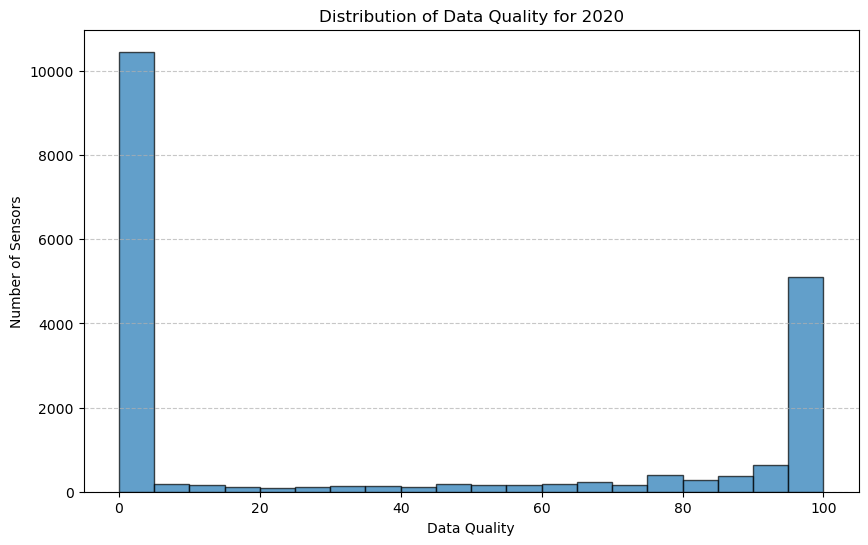

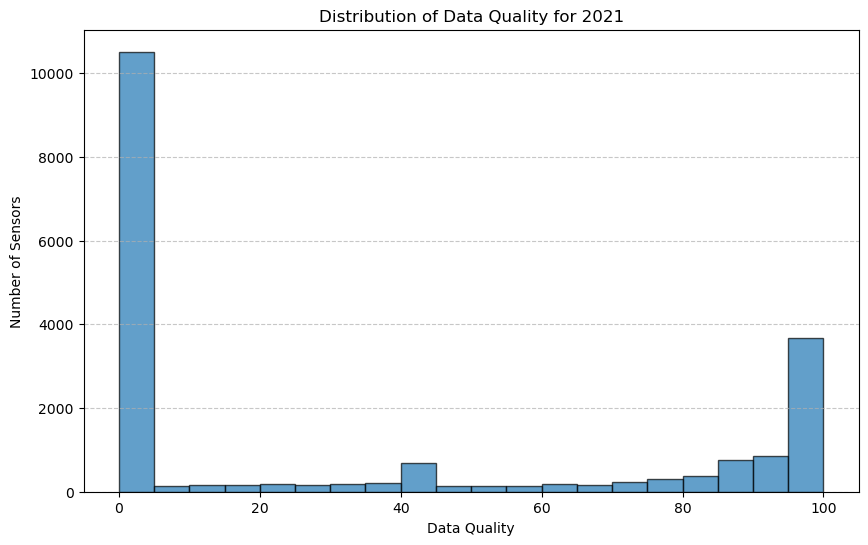

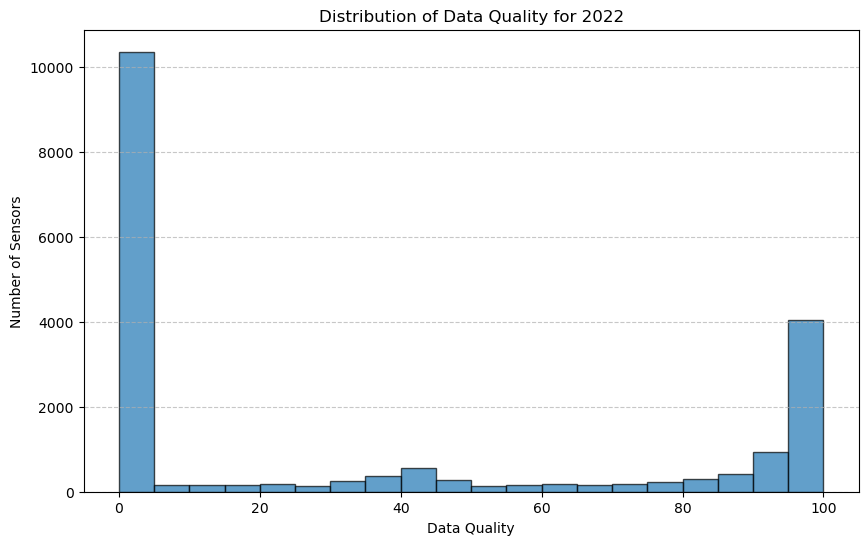

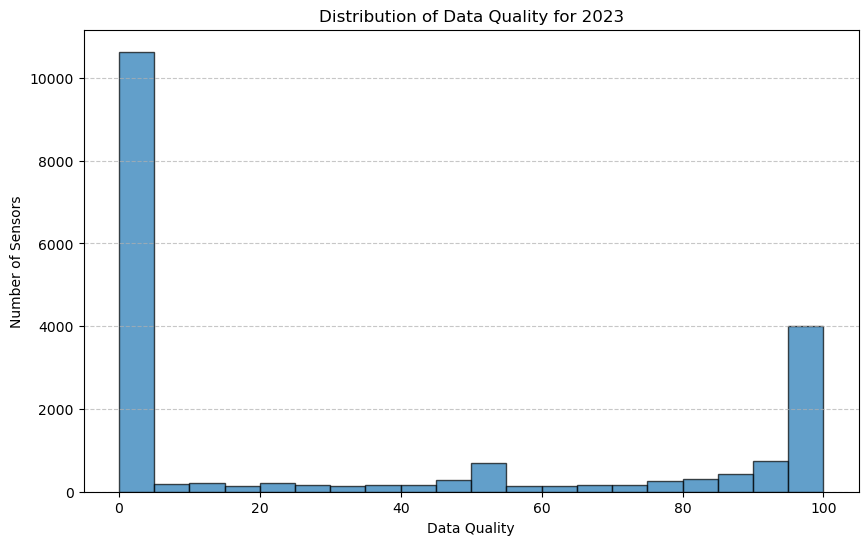

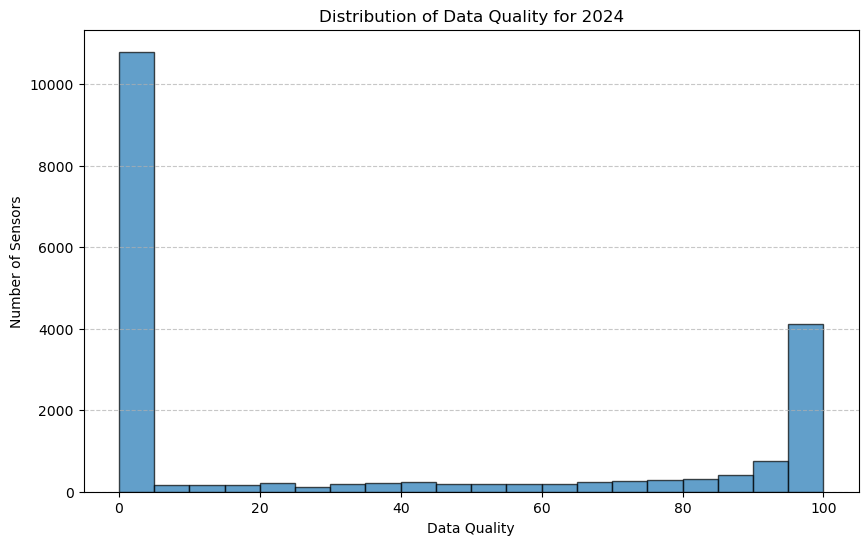

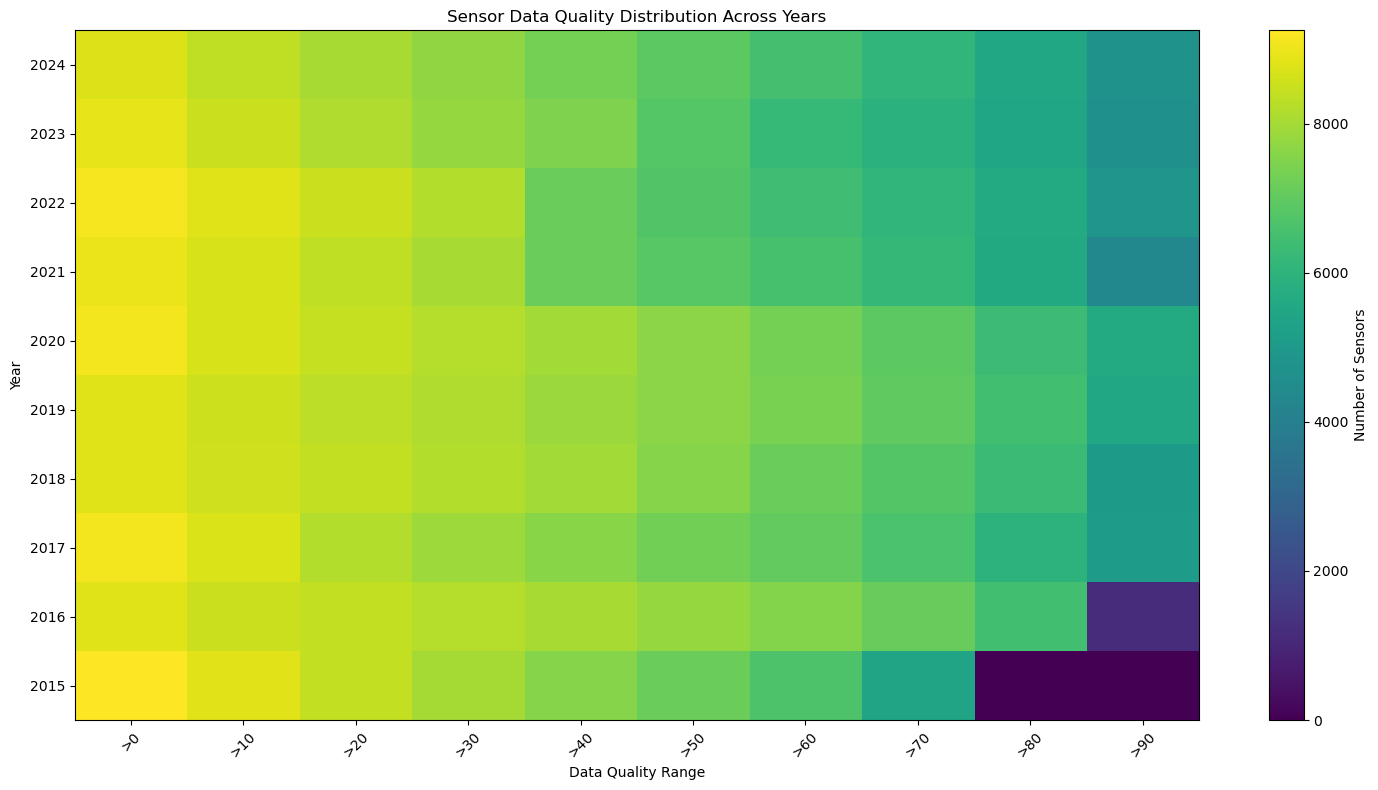

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the processed sensor quality data
data = pd.read_csv("sensor_quality_2015-2024.csv")

# Extract years from the column names (assume they are like '2015_data_quality')
years = [col.split("_")[0] for col in data.columns if "_data_quality" in col]
years = sorted(list(map(int, years)))

# Generate histograms for each year
for year in years:
    year_col = f"{year}_data_quality"
    plt.figure(figsize=(10, 6))
    plt.hist(data[year_col].dropna(), bins=20, edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of Data Quality for {year}")
    plt.xlabel("Data Quality")
    plt.ylabel("Number of Sensors")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Define thresholds for cumulative bins
thresholds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
range_labels = [f">{t}" for t in thresholds]
range_matrix = pd.DataFrame(index=years, columns=range_labels)

# Populate cumulative counts
for year in years:
    year_col = f"{year}_data_quality"
    sensor_quality = data[year_col].dropna()
    for t in thresholds:
        count = (sensor_quality > t).sum()
        range_matrix.loc[year, f">{t}"] = count

# Save the matrix to review
range_matrix.to_csv("sensor_quality_summary_2015-2024.csv", index=True)

# Visualize the resulting matrix
plt.figure(figsize=(15, 8))
plt.imshow(range_matrix.astype(int), aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Number of Sensors')
plt.xticks(ticks=np.arange(len(range_labels)), labels=range_labels, rotation=45)
plt.yticks(ticks=np.arange(len(years)), labels=years)
plt.title("Sensor Data Quality Distribution Across Years")
plt.xlabel("Data Quality Range")
plt.ylabel("Year")
plt.tight_layout()
plt.show()